In [20]:
import numpy as np
import networkx as nx
from networkx import grid_graph

In [21]:
def sampling_algorithm_1():

    for j in range(N):
        sample = []
        A = K.copy()

        if np.random.rand() < A[j][j]:
            sample.append(j)
        else:
            A[j, j] -= 1

        A[j+1:, j] /= A[j, j]
        A[j+1:, j+1:] -= np.outer(A[j+1:, j], A[j, j+1:])

        return sample, A


# Uniform Spanning Trees

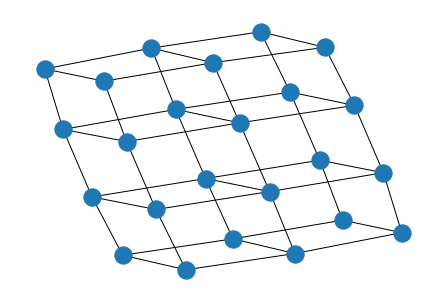

In [22]:
# Create a uniform spanning tree
G = grid_graph(dim=(2, 3, 4))
nx.draw(G)
